### Loading the super-tensor and creating the temporal networks

To load the super tensor and compute the netowork measures on the data the class __temporal_network__ is used.

In [1]:
import numpy                 as     np
import matplotlib.pyplot     as     plt
from   GDa.temporal_network  import temporal_network

To instantiate the __temporal_network__ we have to supply the monkey name, the session, and date to its constructor.

In [2]:
# Instantiating a temporal network object
net =  temporal_network(monkey='lucy', date=150128, session=1)

When instantiated the temporal network object will load the recording info for the monkey, date, and sesion specified as well as the super tensor;

The super-tensor has dimensions [Number of pairs, Number of frequency bands, Number of trials * Time]. So far we are using the following bands:

- $\theta$  = [4,8[    Hz;
- $\alpha$  = [8,15[   Hz;
- $\beta$   = [15,30[  Hz;
- $\gamma$  = [30,60[  Hz;

Next, we can plot the supertensor (for better visualization bellow we plot only for ten trials):

Text(0.5, 0, 'Time (s)')

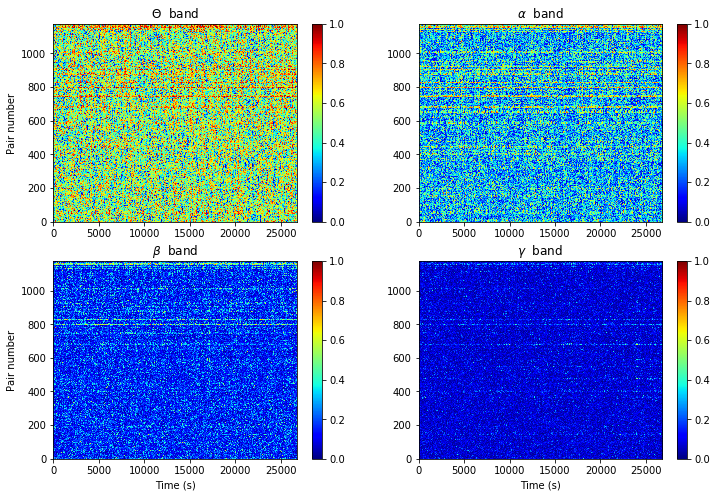

In [23]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(net.super_tensor[:,0,net.t_delay.astype(bool)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\Theta$  band')
plt.ylabel('Pair number')
plt.subplot(2,2,2)
plt.imshow(net.super_tensor[:,1,net.t_delay.astype(bool)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\alpha$  band')
plt.subplot(2,2,3)
plt.imshow(net.super_tensor[:,2,net.t_delay.astype(bool)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\beta$  band')
plt.ylabel('Pair number')
plt.xlabel('Time (s)')
plt.subplot(2,2,4)
plt.imshow(net.super_tensor[:,3,net.t_delay.astype(bool)], aspect='auto', cmap='jet', origin='lower', vmin=0, vmax=1); plt.colorbar()
plt.title(r'$\gamma$  band')
plt.xlabel('Time (s)')

The super tensor can be converted to a adjacency tensor by using the method __convert_to_adjacency__:

In [7]:
net.convert_to_adjacency()

The adjacency tensor has dimensions $[nC, nC,Trials,bands,time]$, where $nC$ is the number of channels, and bands the number of frequency bands.

In [8]:
print('Adjacency tensor shape = ' + str( net.A.shape) )

Adjacency tensor shape = (49, 49, 4, 131760)


Let's plot one layer of the adjacency tensor below:

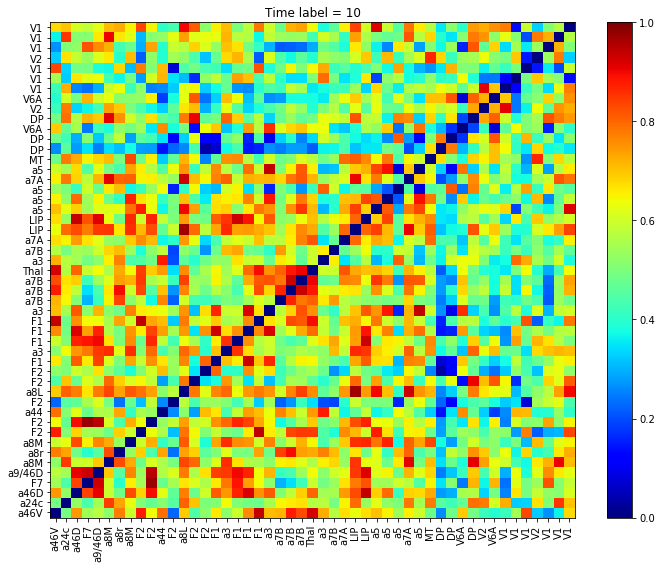

In [6]:
plt.figure(figsize=(10,8))
plt.imshow(net.A[:,:,0,0,10]+net.A[:,:,0,0,10].T,aspect='auto',cmap='jet',origin='lower', vmin=0, vmax=1);plt.colorbar()
plt.title('Time label = ' + str(10))
plt.xticks(range(49), net.session_info['areas'], rotation = 90)
plt.yticks(range(49), net.session_info['areas'])
plt.tight_layout()

In [7]:
A = net.A.swapaxes(2,3)
A = A.reshape([49,49,4,540*244])
A.shape

(49, 49, 4, 131760)

In [9]:
st = net.A.sum(axis=1)

In [31]:
st.shape

(49, 540, 4, 244)

In [33]:
st = np.swapaxes(st,1,2)
st = st.reshape((49,4,540*244))

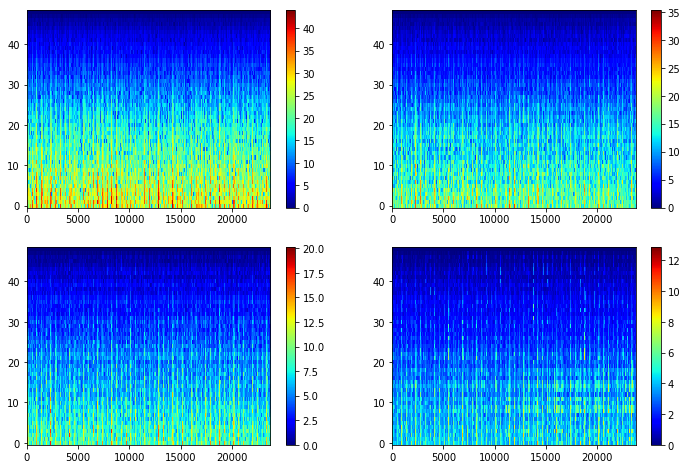

In [15]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(st[:,0,net.t_baseline.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(st[:,1,net.t_baseline.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(st[:,2,net.t_baseline.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(st[:,3,net.t_baseline.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

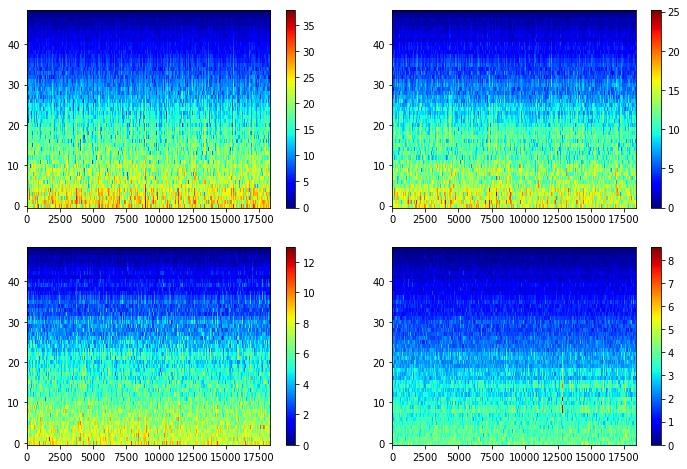

In [16]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(st[:,0,net.t_cue.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(st[:,1,net.t_cue.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(st[:,2,net.t_cue.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(st[:,3,net.t_cue.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

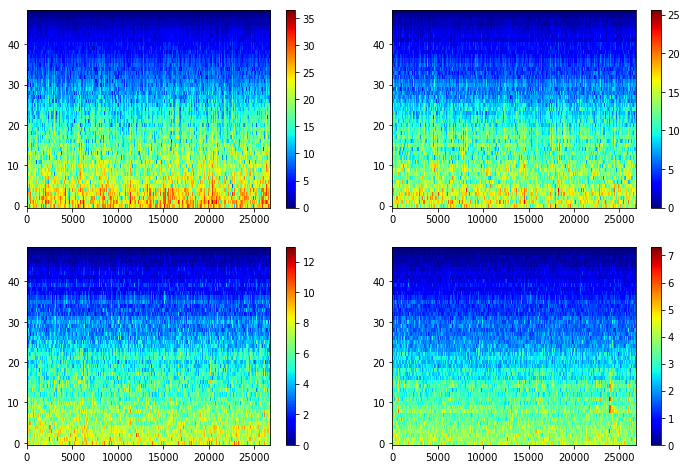

In [17]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(st[:,0,net.t_delay.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(st[:,1,net.t_delay.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(st[:,2,net.t_delay.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(st[:,3,net.t_delay.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

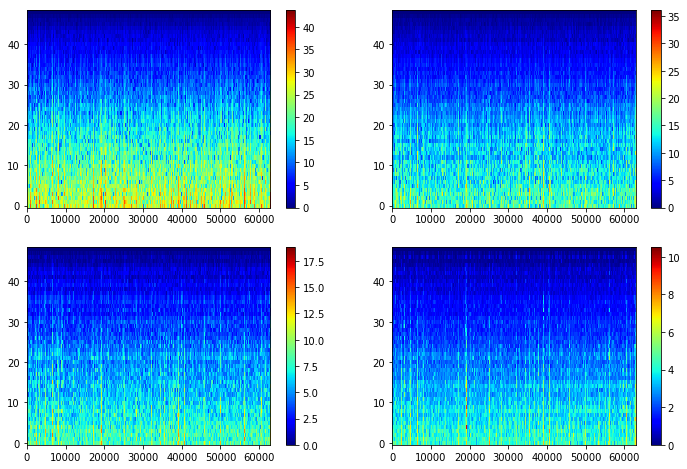

In [19]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(st[:,0,net.tmatch.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(st[:,1,net.tmatch.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(st[:,2,net.tmatch.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(st[:,3,net.tmatch.astype(bool)], aspect = 'auto', cmap = 'jet', origin = 'lower'); plt.colorbar()

In [57]:
import networkx as nx

In [58]:
A = net.A[:,:,0,0,150] > .8
g = nx.Graph(net.A[:,:,0,0,0])

In [60]:
net.session_info['pairs']

array([[ 0,  1],
       [ 0,  2],
       [ 0,  3],
       ...,
       [46, 47],
       [46, 48],
       [47, 48]])

In [61]:
g = nx.from_numpy_matrix(A)

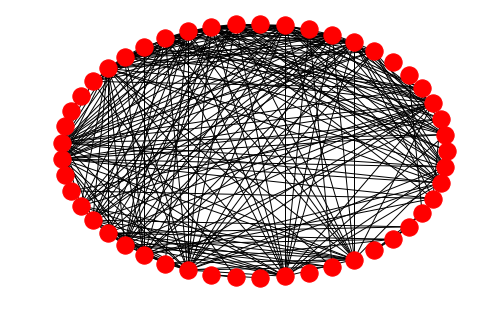

In [62]:
nx.draw_circular(g)

In [33]:
']):a = dict.fromkeys((range(49)))

In [36]:
a.values = net.session_info['areas']

AttributeError: 'dict' object attribute 'values' is read-only

In [37]:
net.session_info['areas']

array(['a46V', 'a24c', 'a46D', 'F7', 'a9/46D', 'a8M', 'a8r', 'a8M', 'F2',
       'F2', 'a44', 'F2', 'a8L', 'F2', 'F2', 'F1', 'a3', 'F1', 'F1', 'F1',
       'a3', 'a7B', 'a7B', 'a7B', 'Thal', 'a3', 'a7B', 'a7A', 'LIP',
       'LIP', 'a5', 'a5', 'a5', 'a7A', 'a5', 'MT', 'DP', 'DP', 'V6A',
       'DP', 'V2', 'V6A', 'V1', 'V1', 'V1', 'V2', 'V1', 'V1', 'V1'],
      dtype=object)

In [38]:
for i in range(49):
    a[i] = net.session_info['areas'][i]

In [55]:
len(net.session_info['areas'])

49

In [69]:
graphs = np.zeros([len(net.bands), net.session_info['nT'], len(net.tarray)], dtype=object)

In [68]:
nx.Graph(net.A[:,:,j,i,k])

In [71]:
i

0

In [72]:
j

299

In [73]:
k

186

In [11]:
net.session_info['t_cue_off']

array([1371., 1600., 1528., 1480., 1489., 1473., 1341., 1553., 1509.,
       1528., 1572., 1447., 1354., 1481., 1541., 1501., 1529., 1464.,
       1570., 1341., 1493., 1341., 1533., 1525., 1486., 1763., 1341.,
       1538., 1533., 1499., 1498., 1534., 1514., 1527., 1473., 1478.,
       1540., 1541., 1461., 1554., 1487., 1526., 1473., 1535., 1701.,
       1494., 1542., 1360., 1550., 1458., 1340., 1513., 1549., 1513.,
       1339., 1508., 1512., 1548., 1353., 1474., 1349., 1568., 1579.,
       1489., 1447., 1581., 1340., 1340., 1339., 1340., 1337., 1619.,
       1479., 1527., 1539., 1473., 1339., 1340., 1354., 1573., 1338.,
       1347., 1352., 1354., 1352., 1352., 1512., 1340., 1352., 1543.,
       1472., 1360., 1513., 1512., 1352., 1353., 1632., 1527., 1472.,
       1352., 1353., 1469., 1631., 1587., 1518., 1593., 1543., 1488.,
       1513., 1353., 1339., 1513., 1460., 1340., 1342., 1354., 1459.,
       1578., 1485., 1525., 1341., 1352., 1334., 1339., 1339., 1352.,
       1516., 1645.,

In [9]:
net.session_info['tarray']

array([-0.65 , -0.649, -0.648, ...,  2.998,  2.999,  3.   ])

In [12]:
def return_stage_time_axis(stage):
    

SyntaxError: unexpected EOF while parsing (<ipython-input-12-92006e4da7cc>, line 2)

In [13]:
(net.session_info['tarray >= 0)*(net.session_info['tarray'] >= 0)

array([ True,  True,  True, ..., False, False, False])

In [48]:
tt = np.tile(net.tarray , (540,1))

In [122]:
tco = (net.session_info['t_cue_off']-net.session_info['t_cue_on'])/1000
tmo = (net.session_info['t_match_on']-net.session_info['t_cue_on'])/1000
stages = np.zeros([540,244])

In [123]:
i1 = ( (tt<0) ).astype(int)
i2 = ( (tt>=0)*(tt<tco[:,None]) ).astype(int)
i3 = ( (tt>=tco[:,None])*(tt<tmo[:,None]) ).astype(int)
i4 = ( (tt>=tmo[:,None]) ).astype(int)
ii = [i1,i2,i3,i4]
#stages[i1] = 1
#stages[i2] = 2
#stages[i3] = 3
#stages[i4] = 4

for i in range(4):
    stages = stages - i * ii[i]

Text(0.5, 0, 'Time')

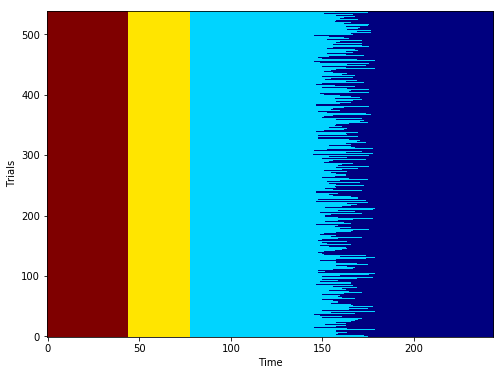

In [124]:
plt.figure(figsize = (8,6))
plt.imshow(stages, aspect='auto',cmap='jet',origin='lower')
plt.ylabel('Trials')
plt.xlabel('Time')

In [38]:
a.shape

(540, 244)

In [50]:
tmo

array([0.52 , 0.507, 0.507, 0.507, 0.52 , 0.507, 0.506, 0.507, 0.507,
       0.52 , 0.506, 0.519, 0.52 , 0.52 , 0.52 , 0.507, 0.52 , 0.507,
       0.506, 0.506, 0.52 , 0.507, 0.506, 0.519, 0.52 , 0.52 , 0.506,
       0.506, 0.52 , 0.506, 0.507, 0.519, 0.52 , 0.52 , 0.52 , 0.52 ,
       0.52 , 0.506, 0.507, 0.507, 0.507, 0.52 , 0.52 , 0.507, 0.52 ,
       0.506, 0.52 , 0.52 , 0.506, 0.507, 0.507, 0.506, 0.52 , 0.506,
       0.507, 0.52 , 0.506, 0.52 , 0.52 , 0.506, 0.52 , 0.507, 0.506,
       0.52 , 0.52 , 0.52 , 0.507, 0.507, 0.507, 0.507, 0.507, 0.519,
       0.506, 0.52 , 0.52 , 0.507, 0.507, 0.507, 0.52 , 0.507, 0.506,
       0.52 , 0.519, 0.52 , 0.52 , 0.52 , 0.507, 0.507, 0.52 , 0.506,
       0.506, 0.52 , 0.506, 0.506, 0.519, 0.52 , 0.52 , 0.507, 0.507,
       0.52 , 0.519, 0.52 , 0.519, 0.507, 0.52 , 0.52 , 0.52 , 0.507,
       0.52 , 0.52 , 0.506, 0.52 , 0.507, 0.507, 0.507, 0.52 , 0.507,
       0.52 , 0.507, 0.52 , 0.506, 0.52 , 0.506, 0.507, 0.506, 0.52 ,
       0.52 , 0.506,

In [55]:
np.std(tmo[:,None])

0.0065314316015275065

In [57]:
np.std( net.session_info['dcue'] / 1000 )

0.0065314316015275065

In [72]:
stages[i1].shape

(540, 244, 244)

In [82]:
i1.shape

(540, 244)

In [125]:
b=i3.reshape(540*244)

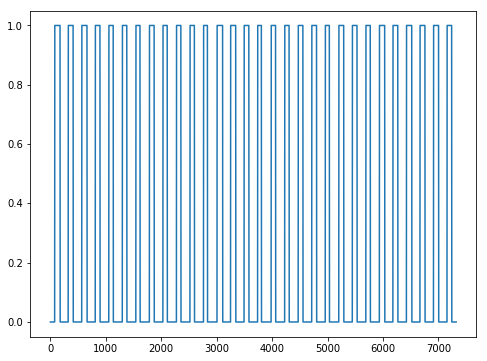

In [94]:
plt.figure(figsize=(8,6))
plt.plot(b[:30*244])

In [108]:
i3.sum(axis=1)

array([ 97,  89,  95,  85,  80,  81,  75,  86,  78,  80,  80,  71, 101,
        93,  86,  68,  80,  80,  85,  87,  74,  89,  85,  80,  96,  88,
        96,  90,  92,  84,  94,  93,  72,  83,  68,  71,  95,  68,  90,
        77,  77,  77, 101,  72,  87,  87,  93,  97,  87,  96, 100,  99,
        89,  88,  71,  77,  81,  89,  81,  68,  78,  72,  95,  90,  77,
        83,  81,  87,  82,  69,  72,  84,  77,  94,  91,  87,  76,  74,
        85,  79,  83,  91,  84,  78,  87,  89,  69,  79,  88,  72,  88,
        71,  82,  81,  72,  90,  91,  77, 100,  72,  76,  82, 100,  98,
       101,  84,  70,  68,  74,  70,  92,  78,  70,  89,  90,  77,  86,
        73,  80,  97,  89,  91,  88,  80,  80,  83,  71,  80,  97,  96,
        91, 101,  82,  87,  96,  76,  73,  72,  82,  70,  89,  73,  79,
        89,  83,  96,  86,  85,  93,  76,  80,  71,  88,  73,  75,  89,
        72,  86,  79,  70,  86,  72,  81,  69,  94,  77,  99,  80,  96,
        71,  73,  88,  80,  69,  88,  89,  91,  98,  82,  82,  8

In [107]:
(net.session_info['t_match_on']-net.session_info['t_cue_off'])/15

array([ 96.86666667,  89.73333333,  95.06666667,  85.26666667,
        79.13333333,  81.73333333,  75.53333333,  86.2       ,
        78.2       ,  79.93333333,  80.86666667,  70.2       ,
       100.4       ,  92.4       ,  85.33333333,  68.4       ,
        79.06666667,  79.93333333,  85.33333333,  87.06666667,
        73.73333333,  89.73333333,  85.33333333,  80.        ,
        96.        ,  87.06666667,  96.86666667,  90.66666667,
        91.53333333,  84.46666667,  94.2       ,  92.46666667,
        71.06666667,  82.66666667,  67.53333333,  70.2       ,
        94.2       ,  68.4       ,  90.6       ,  77.26666667,
        77.26666667,  76.4       , 100.4       ,  71.93333333,
        86.2       ,  87.06666667,  92.4       ,  96.86666667,
        87.06666667,  95.93333333, 100.4       ,  99.53333333,
        88.86666667,  88.        ,  71.06666667,  76.4       ,
        81.73333333,  88.86666667,  80.86666667,  68.46666667,
        77.33333333,  71.93333333,  95.13333333,  89.73

In [106]:
np.std(tmo-tco)

0.13679312200188765

In [11]:
net.create_stages_time_grid()

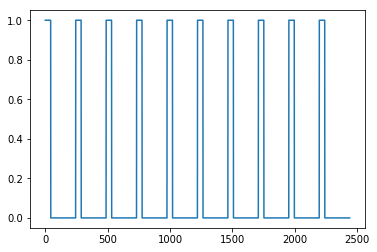

In [7]:
plt.plot(net.t_baseline[:10*244])

In [11]:
net.super_tensor.swapaxes(1,2)

array([[[[0.61369458, 0.59765747, 0.58378035, ..., 0.78683975,
          0.81242034, 0.83387405],
         [0.83061329, 0.80567974, 0.78222063, ..., 0.80387446,
          0.80048102, 0.79545388],
         [0.94895911, 0.92891902, 0.90151912, ..., 0.86869249,
          0.87170598, 0.86971155],
         ...,
         [0.54016239, 0.54349874, 0.55024473, ..., 0.48755945,
          0.49046218, 0.50184701],
         [0.94525206, 0.93048993, 0.91310677, ..., 0.86860386,
          0.88895845, 0.90746373],
         [0.89174357, 0.88213414, 0.87270012, ..., 0.90132743,
          0.90176514, 0.89945176]],

        [[0.59645756, 0.58711468, 0.57711721, ..., 0.51364443,
          0.53244944, 0.55339441],
         [0.41310528, 0.43474911, 0.45911919, ..., 0.93302138,
          0.93557352, 0.93647332],
         [0.86648293, 0.84080571, 0.82150276, ..., 0.82031627,
          0.84207113, 0.85496426],
         ...,
         [0.56802409, 0.53514416, 0.51977876, ..., 0.39107473,
          0.40210319, 0.4

In [12]:
net.super_tensor.shape

(1176, 540, 4, 244)

In [13]:
net.t_baseline.

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
plt.hist( net.super_tensor[:,1,net.t_baseline.astype(bool)],100 )
plt.subplot(2,2,2)
plt.hist( net.super_tensor[:,1,net.t_cue.astype(bool)],100 )
plt.subplot(2,2,3)
plt.hist( net.super_tensor[:,1,net.t_delay.astype(bool)],100 )
plt.subplot(2,2,4)
plt.hist( net.super_tensor[:,1,net.tmatch.astype(bool)],100 )